## According to the salishseacast results what do we expect to see form the 2017 CIOPS results? How does 2017 compare to other years according to the SSC results?

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
import statistics as stat
import scipy
import cmath
from scipy import signal
import gsw.conversions as gsw
from pathlib import Path

In [2]:
def get_data(mydata, starttime, endtime):
    transports = (mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    salt = (mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])
    P = (mydata.init_depth[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])
    temp = gsw.t_from_CT(salt,(mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]),P)
    
    return np.sum(transports), temp, salt

In [3]:
def check_mask(value):
    if str(type(value)) == "<class 'numpy.float64'>":
        return True
    else:
        return False

In [6]:
dates = np.array([dt.datetime(2016,1,1)+relativedelta(months=i) for i in range(12*5)])
dates[9:15] # = winter 2016/17
dates[15:21] # = summer 2017
dates[21:27] # = winter 2016/2017

array([datetime.datetime(2017, 10, 1, 0, 0),
       datetime.datetime(2017, 11, 1, 0, 0),
       datetime.datetime(2017, 12, 1, 0, 0),
       datetime.datetime(2018, 1, 1, 0, 0),
       datetime.datetime(2018, 2, 1, 0, 0),
       datetime.datetime(2018, 3, 1, 0, 0)], dtype=object)

In [16]:
winter = np.zeros(len(dates))
summer = np.zeros(len(dates))

for i in range(len(dates)):
    if dates[i].month > 3 and dates[i].month < 10:
        winter[i] = False
        summer[i] = True
    else:
        winter[i] = True
        summer[i] = False

In [17]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sum_trans = np.array([])
avg_temp = np.array([])
max_temp = np.array([])
min_temp = np.array([])
avg_salt = np.array([])
max_salt = np.array([])
min_salt = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        tr, te, sa = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        sum_trans = np.append(sum_trans, tr)
        avg_temp = np.append(avg_temp, np.mean(te))
        max_temp = np.append(max_temp, np.max(te))
        min_temp = np.append(min_temp, np.min(te))
        avg_salt = np.append(avg_salt, np.mean(sa))
        max_salt = np.append(max_salt, np.max(sa))
        min_salt = np.append(min_salt, np.min(sa))

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]
        
        tr, te, sa = get_data(mydata, starttime, endtime)

        sum_trans = np.append(sum_trans, tr)
        avg_temp = np.append(avg_temp, np.mean(te))
        max_temp = np.append(max_temp, np.max(te))
        min_temp = np.append(min_temp, np.min(te))
        avg_salt = np.append(avg_salt, np.mean(sa))
        max_salt = np.append(max_salt, np.max(sa))
        min_salt = np.append(min_salt, np.min(sa))
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    tr, te, sa = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
    sum_trans = np.append(sum_trans, tr)
    avg_temp = np.append(avg_temp, np.mean(te))
    max_temp = np.append(max_temp, np.max(te))
    min_temp = np.append(min_temp, np.min(te))
    avg_salt = np.append(avg_salt, np.mean(sa))
    max_salt = np.append(max_salt, np.max(sa))
    min_salt = np.append(min_salt, np.min(sa))

## Transport

In [7]:
trans_W = np.ma.array(sum_trans, mask=summer)
trans_S = np.ma.array(sum_trans, mask=winter)

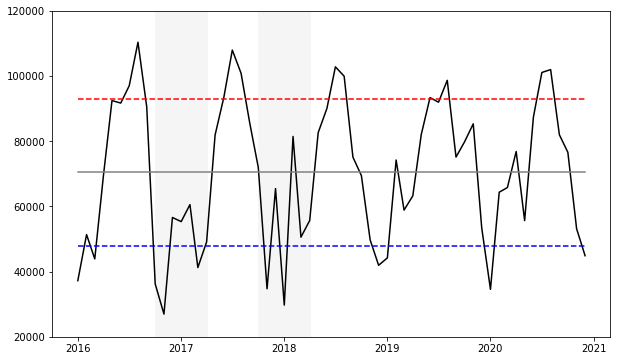

In [8]:
fig, ax = plt.subplots(1,1, figsize=[10,6])
ax.plot(dates, sum_trans, 'k')
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans), np.mean(sum_trans)], 'grey')
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)+stat.stdev(sum_trans), np.mean(sum_trans)+stat.stdev(sum_trans)], 'r--')
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)-stat.stdev(sum_trans), np.mean(sum_trans)-stat.stdev(sum_trans)], 'b--')
ax.set_ylim([20000,120000])

ax.fill_between(dates, 20000, 120000, where=(dates<dates[15+1])&(dates>=dates[9]), color='whitesmoke')
ax.fill_between(dates, 20000, 120000, where=(dates<dates[27+1])&(dates>=dates[21]), color='whitesmoke')

In [9]:
fft = scipy.fft.fft(sum_trans)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=11.1**5)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

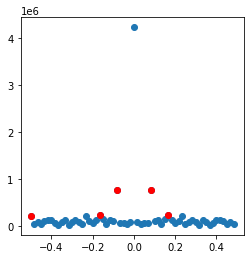

In [10]:
fig, ax = plt.subplots(1,1, figsize=[4,4])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [11]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(20000.0, 120000.0)

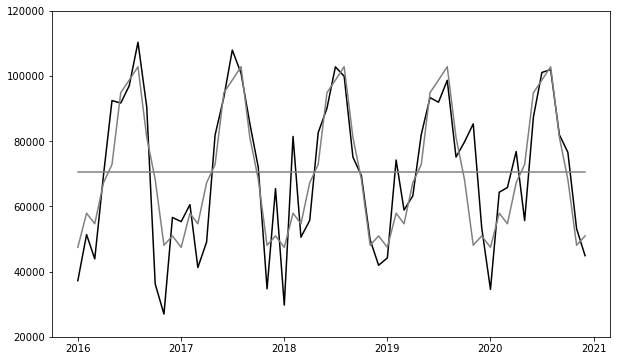

In [12]:
fig, ax = plt.subplots(1,1, figsize=[10,6])
ax.plot(dates, sum_trans, 'k')
ax.plot(dates, scipy.fft.ifft(fft_filtered)+np.mean(sum_trans), color='grey')
# ax.plot([dates[0], dates[-1]],[np.mean(trans_S), np.mean(trans_S)], 'r--', label="average summer transport")
# ax.plot([dates[0], dates[-1]],[np.mean(trans_W), np.mean(trans_W)], 'b--', label="average winter transport")
ax.plot([dates[0], dates[-1]],[np.mean(sum_trans), np.mean(sum_trans)], 'grey')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)+stat.stdev(sum_trans), np.mean(sum_trans)+stat.stdev(sum_trans)], 'r--')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)-stat.stdev(sum_trans), np.mean(sum_trans)-stat.stdev(sum_trans)], 'b--')
ax.set_ylim([20000,120000])

In [13]:
# remove seasonal cycle
trans = sum_trans - (scipy.fft.ifft(fft_filtered)+np.mean(sum_trans))

In [14]:
anomW = np.array(list(filter(check_mask, np.ma.array(trans.real, mask=summer)))) 
anomS = np.array(list(filter(check_mask, np.ma.array(trans.real, mask=winter)))) 

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


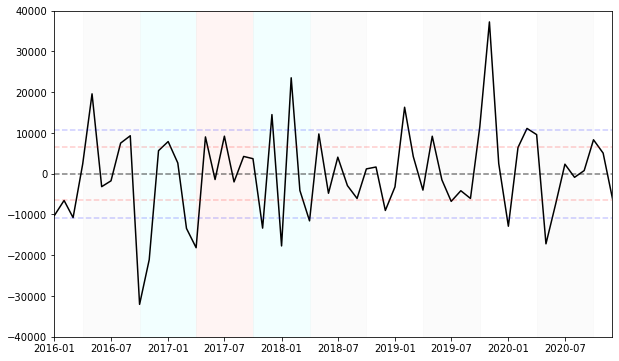

In [15]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, trans, 'k')
ax.plot([dates[0],dates[-1]], [0,0], 'k--', alpha=0.5)
ax.plot([dates[0],dates[-1]], [np.mean(abs(anomW)),np.mean(abs(anomW))], 'b--', alpha=0.2)
ax.plot([dates[0],dates[-1]], [-np.mean(abs(anomW)),-np.mean(abs(anomW))], 'b--', alpha=0.2)
ax.plot([dates[0],dates[-1]], [np.mean(abs(anomS)),np.mean(abs(anomS))], 'r--', alpha=0.2)
ax.plot([dates[0],dates[-1]], [-np.mean(abs(anomS)),-np.mean(abs(anomS))], 'r--', alpha=0.2)
ax.set_ylim([-40000,40000])
ax.set_xlim([dates[0],dates[-1]])

ax.fill_between(dates, -40000,40000, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax.fill_between(dates, -40000,40000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

#### winter 2016/17
- very low flows in the beginning and end of the season
- otherwise only slightly above average flow for the rest of the winter

#### summer 2017
- flows on the higher side but nothing to write home about

#### winter 2017/18
- very variable, switching back and forth between anomalously high and low flows

## Temperature

Text(0, 0.5, 'Temperature $^\\circ C$')

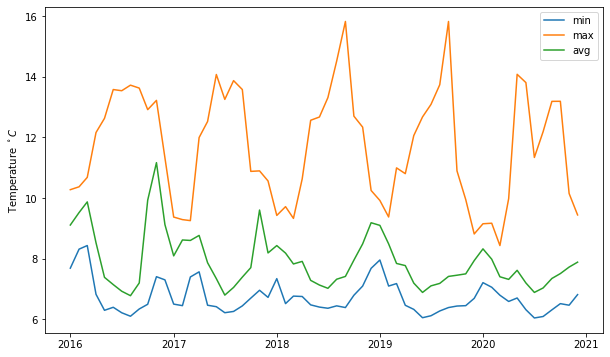

In [20]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_temp, label='min')
ax.plot(dates, max_temp, label='max')
ax.plot(dates, avg_temp, label='avg')
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

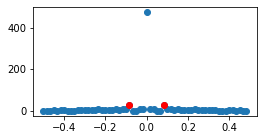

In [21]:
# lets remove the seasonal cycle of ALL OF THEM
# first average

fft = scipy.fft.fft(avg_temp)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=7)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [22]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_avg = scipy.fft.ifft(fft_filtered)+np.mean(avg_temp)

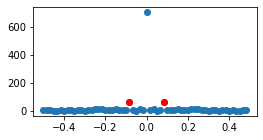

In [23]:
# now max

fft = scipy.fft.fft(max_temp)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=11)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [24]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_max = scipy.fft.ifft(fft_filtered)+np.mean(max_temp)

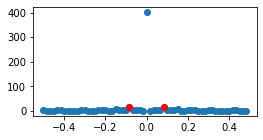

In [25]:
# now min

fft = scipy.fft.fft(min_temp)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=6)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [26]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_min = scipy.fft.ifft(fft_filtered)+np.mean(min_temp)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Temperature $^\\circ C$')

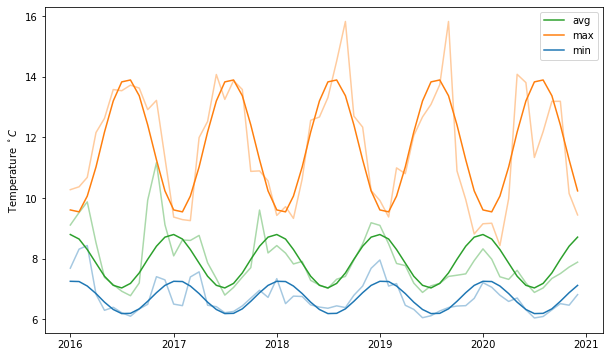

In [27]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_temp, alpha=0.4)
ax.plot(dates, max_temp, alpha=0.4)
ax.plot(dates, avg_temp, alpha=0.4)
ax.plot(dates, seas_avg, label='avg', color='tab:green')
ax.plot(dates, seas_max, label='max', color='tab:orange')
ax.plot(dates, seas_min, label='min', color='tab:blue')
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


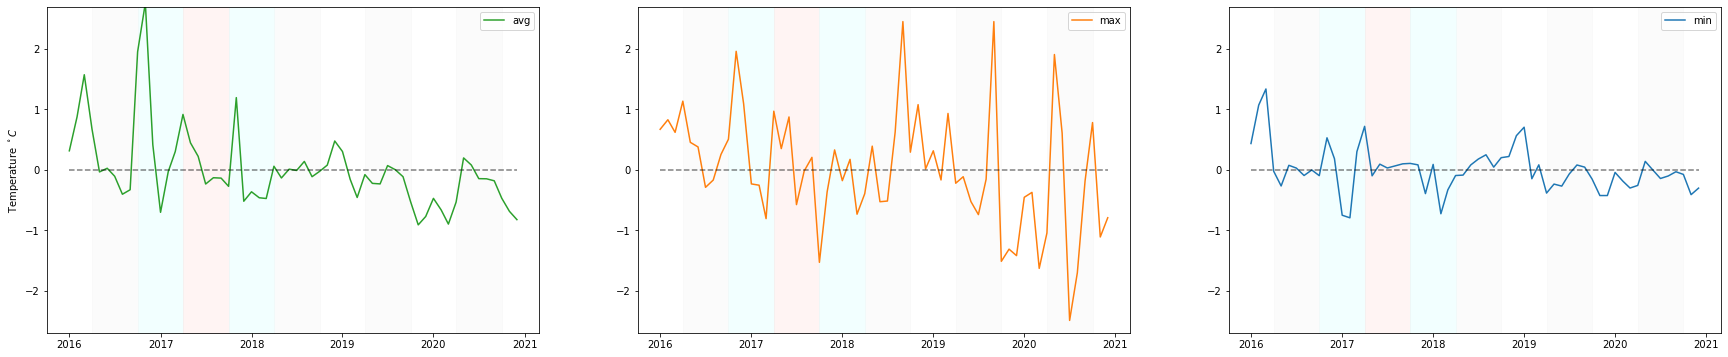

In [28]:
fig, ax = plt.subplots(1,3, figsize=[30,6])

ax[0].plot(dates, avg_temp - seas_avg, label='avg', color='tab:green')
ax[1].plot(dates, max_temp - seas_max, label='max', color='tab:orange')
ax[2].plot(dates, min_temp - seas_min, label='min', color='tab:blue')
ax[0].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[1].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[2].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('Temperature $^\circ C$')

ax[0].set_ylim([-2.7, 2.7])
ax[1].set_ylim([-2.7, 2.7])
ax[2].set_ylim([-2.7, 2.7])

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

- max value range significant compared to min
- max is half a period out of pahse with the min and avg (in teh winter the max, min, and avg are close whereas in the summer with max is very high compared ot the average and min)

#### winter 2016/17
- highest average temperature in the timeseries observed
- late cooling of maximum inflow
- variable minimum temperature

#### summer 2017
- follows the seasonal reasonbly well

#### winter 2017/18
- slightly low min and average but follows the cycle reasonably well

## Salinity

Text(0, 0.5, 'Salinity $g kg^{-1}$')

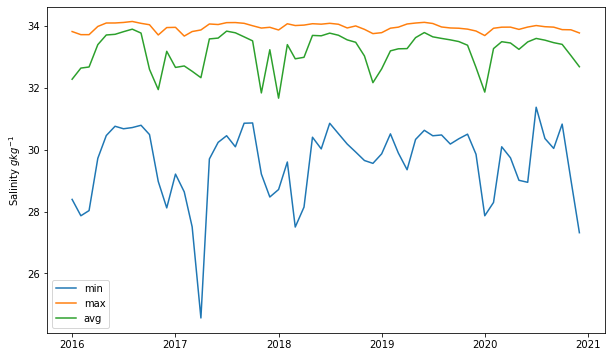

In [29]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_salt, label='min')
ax.plot(dates, max_salt, label='max')
ax.plot(dates, avg_salt, label='avg')
ax.legend()
ax.set_ylabel('Salinity $g kg^{-1}$')

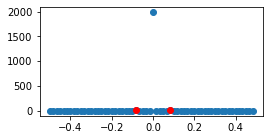

In [30]:
# lets remove the seasonal cycle of ALL OF THEM
# first average

fft = scipy.fft.fft(avg_salt)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=7)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [31]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_avg = scipy.fft.ifft(fft_filtered)+np.mean(avg_salt)

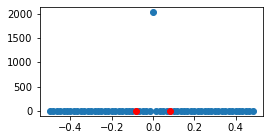

In [32]:
fft = scipy.fft.fft(max_salt)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=3)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [33]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_max = scipy.fft.ifft(fft_filtered)+np.mean(max_salt)

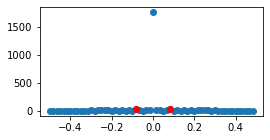

In [34]:
fft = scipy.fft.fft(min_salt)
power = np.abs(fft)
freq = scipy.fft.fftfreq(len(fft),d=1)

peaks = signal.find_peaks(power, prominence=10)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

fig, ax = plt.subplots(1,1, figsize=[4,2])
ax.scatter(freq, power)
ax.scatter(peak_freq,peak_power,color='r')

In [35]:
fft_filtered = np.zeros(len(fft),dtype=np.complex_)
for i in peaks:
    fft_filtered[i] = fft[i]
    
seas_min = scipy.fft.ifft(fft_filtered)+np.mean(min_salt)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


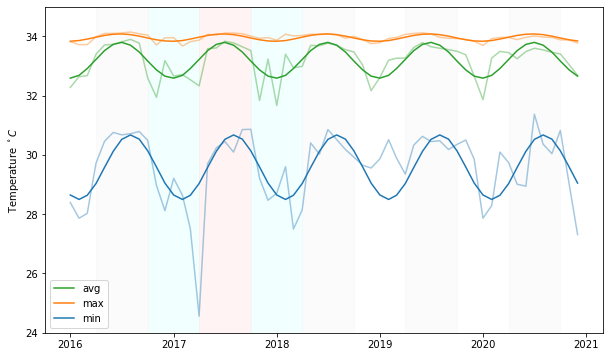

In [36]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_salt, alpha=0.4)
ax.plot(dates, max_salt, alpha=0.4)
ax.plot(dates, avg_salt, alpha=0.4)
ax.plot(dates, seas_avg, label='avg', color='tab:green')
ax.plot(dates, seas_max, label='max', color='tab:orange')
ax.plot(dates, seas_min, label='min', color='tab:blue')
ax.set_ylim([24,35])
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

ax.fill_between(dates, -40000,40000, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax.fill_between(dates, -40000,40000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, -40000,40000, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


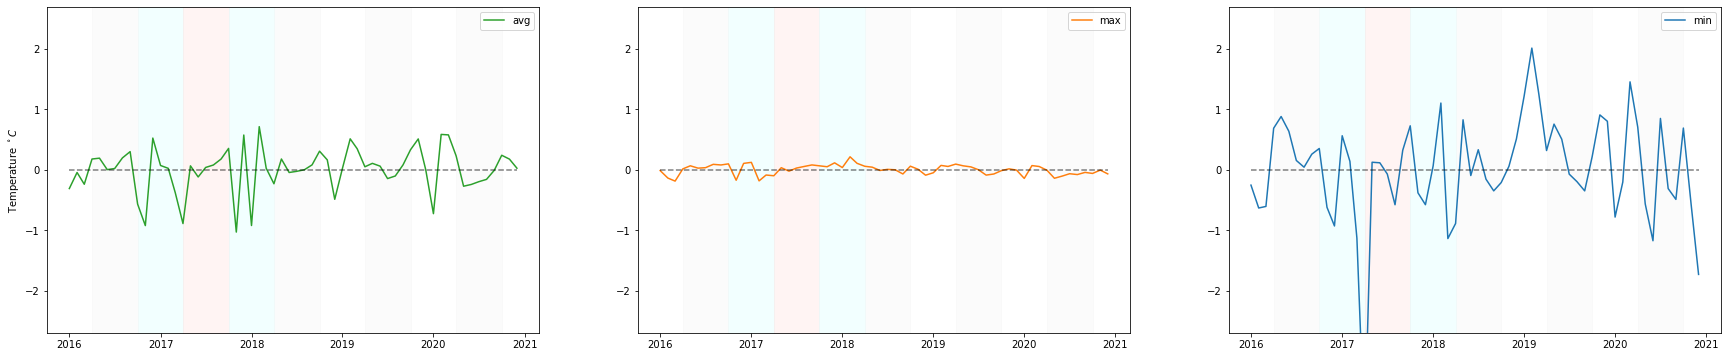

In [37]:
fig, ax = plt.subplots(1,3, figsize=[30,6])

ax[0].plot(dates, avg_salt - seas_avg, label='avg', color='tab:green')
ax[1].plot(dates, max_salt - seas_max, label='max', color='tab:orange')
ax[2].plot(dates, min_salt - seas_min, label='min', color='tab:blue')
ax[0].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[1].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[2].plot([dates[0], dates[-1]], [0,0], 'k--', alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('Temperature $^\circ C$')

ax[0].set_ylim([-2.7, 2.7])
ax[1].set_ylim([-2.7, 2.7])
ax[2].set_ylim([-2.7, 2.7])

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[0].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[1].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[15+1])&(dates>=dates[9]), color='lightcyan', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[21+1])&(dates>=dates[15]), color='mistyrose', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[27+1])&(dates>=dates[21]), color='lightcyan', alpha=0.4)

ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax[2].fill_between(dates, -2.7,2.7, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4)

- min value range significant, max range is tiny
- max and average trough occurs in Januarybut min is in February

#### winter 2016/17
- lowest salt inlfow in timseries in april of 2017, march also low

#### summer 2017
- all parameters follow the seasonal reasonbly well, fluctuation above and bellow expected

#### winter 2017/18
- max follows the seasonal well
- the min is relatively good but like all other winters lots of fluctuation
- more fluctuation in the average than in other winters, looks similar to transport fluctuation in this same year

## 2017 Tracer Histograms

In [38]:
# get data for winter 2016/17
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
time = dec_end - oct_start + 1

temp1 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
salt1 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
transport1 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

jan_start = 1
mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
time = mar_end - jan_start + 1

temp2 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]
salt2 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]
transport2 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time

tranW16 = np.append(transport1, transport2)
saltW16 = np.append(salt1, salt2)
tempW16 = np.append(temp1, temp2)

In [39]:
# get data for winter 2017/18

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
time = dec_end - oct_start + 1

temp1 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
salt1 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
transport1 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

months = ['jan', 'feb', 'mar']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]
time = mar_end - jan_start + 1 #i think that even though you are going month by month since you are adding up months you want to take time as the full span
temp2 = []
salt2 = []
transport2 = []

for file in files:
    mydata = xr.open_dataset(file)
    temp2 = np.append(temp2, mydata['init_temp'][(mydata.final_section != 0)])
    salt2 = np.append(salt2, mydata['init_salt'][(mydata.final_section != 0)])
    transport2 = np.append(transport2, mydata.init_transp[(mydata.final_section != 0)]/time)

tranW17 = np.append(transport1, transport2)
saltW17 = np.append(salt1, salt2)
tempW17 = np.append(temp1, temp2)

In [40]:
# get data for summer 2017

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
time = sep_end - apr_start +1

tempS17 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
saltS17 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
tranS17 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time

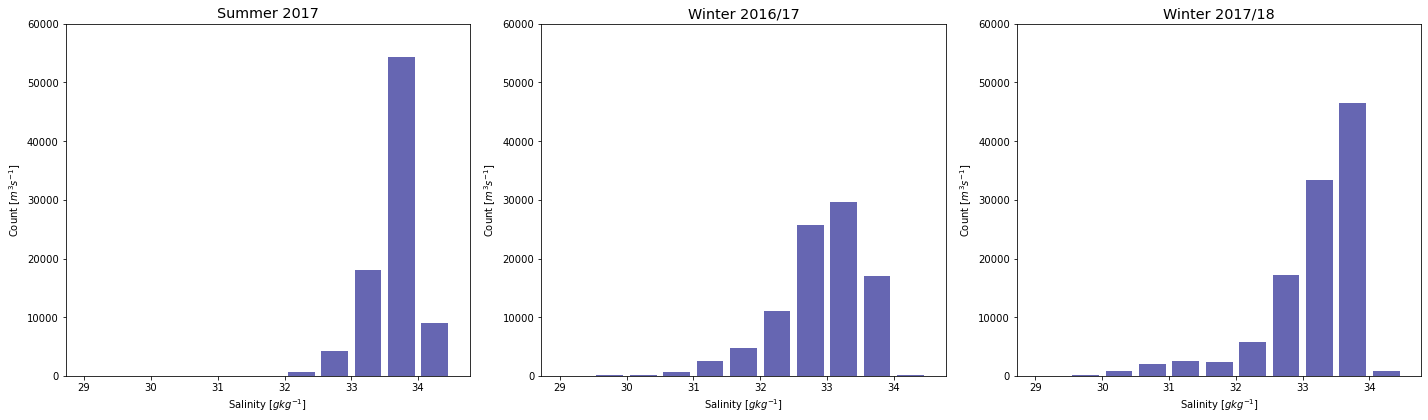

In [41]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
plt.rcParams['font.size'] = 12
#plt summer
sum_sal,x,_ = ax[0].hist(saltS17, bins=np.arange(29,35,0.5), weights= tranS17, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

ax[0].bar(bin_centers,sum_sal, color='navy', alpha=0.6, width = 0.4)

ax[0].set_title('Summer 2017')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Salinity [$g kg^{-1}$]')
ax[0].set_ylim([0,60000])
# ax[0].legend()

#plt winter
win_sal,x,_ = ax[1].hist(saltW16, bins=np.arange(29,35,0.5), weights= tranW16, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

ax[1].bar(bin_centers,win_sal, color='navy', alpha=0.6, width=0.4)

ax[1].set_title('Winter 2016/17')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Salinity [$g kg^{-1}$]')
ax[1].set_ylim([0,60000])
# ax[1].legend()

#plt winter
win_sal,x,_ = ax[2].hist(saltW17, bins=np.arange(29,35,0.5), weights= tranW17, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

ax[2].bar(bin_centers,win_sal, color='navy', alpha=0.6, width=0.4)

ax[2].set_title('Winter 2017/18')
ax[2].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[2].set_xlabel('Salinity [$g kg^{-1}$]')
ax[2].set_ylim([0,60000])
# ax[1].legend()

plt.tight_layout();

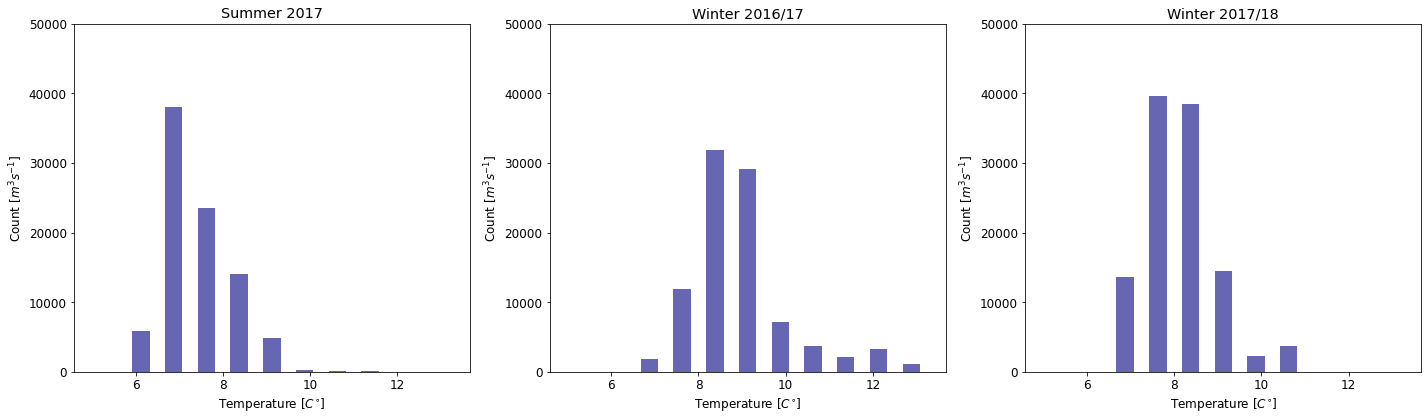

In [42]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
plt.rcParams['font.size'] = 12
#plt summer
sum_temp,x,_ = ax[0].hist(tempS17, bins=np.arange(5,14,0.75), weights= tranS17, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

ax[0].bar(bin_centers,sum_temp, color='navy', alpha=0.6, width = 0.4)

ax[0].set_title('Summer 2017')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Temperature [$C^{\circ}$]')
ax[0].set_ylim([0,50000])
# ax[0].legend()

#plt winter
win_temp16,x,_ = ax[1].hist(tempW16, bins=np.arange(5,14,0.75), weights= tranW16, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

ax[1].bar(bin_centers,win_temp16, color='navy', alpha=0.6, width=0.4)

ax[1].set_title('Winter 2016/17')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Temperature [$C^{\circ}$]')
ax[1].set_ylim([0,50000])
# ax[1].legend()

#plt winter
win_temp17,x,_ = ax[2].hist(tempW17, bins=np.arange(5,14,0.75), weights= tranW17, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

ax[2].bar(bin_centers,win_temp17, color='navy', alpha=0.6, width=0.4)

ax[2].set_title('Winter 2017/18')
ax[2].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[2].set_xlabel('Temperature [$C^{\circ}$]')
ax[2].set_ylim([0,50000])
# ax[1].legend()

plt.tight_layout();

# How do timeseries of the CIOPS results compare??

In [7]:
Cdates = dates[9:27]

In [8]:
monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

mon17 = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [9]:
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_30sep17/ariane_positions_quantitative.nc')

Fapr17 = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])/(sum_end[0]-sum_start[0]+1)
Fmay17 = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])/(sum_end[1]-sum_start[1]+1)
Fjun17 = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])/(sum_end[2]-sum_start[2]+1)
Fjul17 = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])/(sum_end[3]-sum_start[3]+1)
Faug17 = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])/(sum_end[4]-sum_start[4]+1)
Fsep17 = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])/(sum_end[5]-sum_start[5]+1)

Sapr17 = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])
Smay17 = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])
Sjun17 = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])
Sjul17 = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])
Saug17 = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])
Ssep17 = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])

Tapr17 = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])
Tmay17 = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])
Tjun17 = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])
Tjul17 = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])
Taug17 = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])
Tsep17 = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])

In [10]:
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar17/ariane_positions_quantitative.nc')

Foct16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[0]) & (Wdata16.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1)
Fnov16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[1]) & (Wdata16.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1)
Fdec16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[2]) & (Wdata16.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1)
Fjan16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[3]) & (Wdata16.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1)
Ffeb16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[4]) & (Wdata16.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1)
Fmar16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[5]) & (Wdata16.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1)

Soct16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[0]) & (Wdata16.init_t <= win_end[0])])
Snov16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[1]) & (Wdata16.init_t <= win_end[1])])
Sdec16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[2]) & (Wdata16.init_t <= win_end[2])])
Sjan16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[3]) & (Wdata16.init_t <= win_end[3])])
Sfeb16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[4]) & (Wdata16.init_t <= win_end[4])])
Smar16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[5]) & (Wdata16.init_t <= win_end[5])])

Toct16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[0]) & (Wdata16.init_t <= win_end[0])])
Tnov16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[1]) & (Wdata16.init_t <= win_end[1])])
Tdec16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[2]) & (Wdata16.init_t <= win_end[2])])
Tjan16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[3]) & (Wdata16.init_t <= win_end[3])])
Tfeb16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[4]) & (Wdata16.init_t <= win_end[4])])
Tmar16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[5]) & (Wdata16.init_t <= win_end[5])])

In [11]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar18/ariane_positions_quantitative.nc')

Foct17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[0]) & (Wdata17.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1)
Fnov17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[1]) & (Wdata17.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1)
Fdec17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[2]) & (Wdata17.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1)
Fjan17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[3]) & (Wdata17.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1)
Ffeb17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[4]) & (Wdata17.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1)
Fmar17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[5]) & (Wdata17.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1)

Soct17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[0]) & (Wdata17.init_t <= win_end[0])])
Snov17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[1]) & (Wdata17.init_t <= win_end[1])])
Sdec17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[2]) & (Wdata17.init_t <= win_end[2])])
Sjan17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[3]) & (Wdata17.init_t <= win_end[3])])
Sfeb17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[4]) & (Wdata17.init_t <= win_end[4])])
Smar17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[5]) & (Wdata17.init_t <= win_end[5])])

Toct17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[0]) & (Wdata17.init_t <= win_end[0])])
Tnov17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[1]) & (Wdata17.init_t <= win_end[1])])
Tdec17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[2]) & (Wdata17.init_t <= win_end[2])])
Tjan17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[3]) & (Wdata17.init_t <= win_end[3])])
Tfeb17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[4]) & (Wdata17.init_t <= win_end[4])])
Tmar17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[5]) & (Wdata17.init_t <= win_end[5])])

In [12]:
#comparison arrays
Csum_trans = [sum(Foct16), sum(Fnov16), sum(Fdec16), sum(Fjan16), sum(Ffeb16), sum(Fmar16), sum(Fapr17), sum(Fmay17), sum(Fjun17), sum(Fjul17), sum(Faug17), sum(Fsep17) ,sum(Foct17), sum(Fnov17), sum(Fdec17), sum(Fjan17), sum(Ffeb17), sum(Fmar17)]

In [13]:
Ctemp_avg = [np.mean(Toct16), np.mean(Tnov16), np.mean(Tdec16), np.mean(Tjan16), np.mean(Tfeb16), np.mean(Tmar16), np.mean(Tapr17), np.mean(Tmay17), np.mean(Tjun17), np.mean(Tjul17), np.mean(Taug17), np.mean(Tsep17) ,np.mean(Toct17), np.mean(Tnov17), np.mean(Tdec17), np.mean(Tjan17), np.mean(Tfeb17), np.mean(Tmar17)]
Ctemp_max = [np.max(Toct16), np.max(Tnov16), np.max(Tdec16), np.max(Tjan16), np.max(Tfeb16), np.max(Tmar16), np.max(Tapr17), np.max(Tmay17), np.max(Tjun17), np.max(Tjul17), np.max(Taug17), np.max(Tsep17), np.max(Toct17), np.max(Tnov17), np.max(Tdec17), np.max(Tjan17), np.max(Tfeb17), np.max(Tmar17)]
Ctemp_min = [np.min(Toct16), np.min(Tnov16), np.min(Tdec16), np.min(Tjan16), np.min(Tfeb16), np.min(Tmar16), np.min(Tapr17), np.min(Tmay17), np.min(Tjun17), np.min(Tjul17), np.min(Taug17), np.min(Tsep17), np.min(Toct17), np.min(Tnov17), np.min(Tdec17), np.min(Tjan17), np.min(Tfeb17), np.min(Tmar17)]

Csal_avg = [np.mean(Soct16), np.mean(Snov16), np.mean(Sdec16), np.mean(Sjan16), np.mean(Sfeb16), np.mean(Smar16), np.mean(Sapr17), np.mean(Smay17), np.mean(Sjun17), np.mean(Sjul17), np.mean(Saug17), np.mean(Ssep17) ,np.mean(Soct17), np.mean(Snov17), np.mean(Sdec17), np.mean(Sjan17), np.mean(Sfeb17), np.mean(Smar17)]
Csal_max = [np.max(Soct16), np.max(Snov16), np.max(Sdec16), np.max(Sjan16), np.max(Sfeb16), np.max(Smar16), np.max(Sapr17), np.max(Smay17), np.max(Sjun17), np.max(Sjul17), np.max(Saug17), np.max(Ssep17), np.max(Soct17), np.max(Snov17), np.max(Sdec17), np.max(Sjan17), np.max(Sfeb17), np.max(Smar17)]
Csal_min = [np.min(Soct16), np.min(Snov16), np.min(Sdec16), np.min(Sjan16), np.min(Sfeb16), np.min(Smar16), np.min(Sapr17), np.min(Smay17), np.min(Sjun17), np.min(Sjul17), np.min(Saug17), np.min(Ssep17), np.min(Soct17), np.min(Snov17), np.min(Sdec17), np.min(Sjan17), np.min(Sfeb17), np.min(Smar17)]


In [14]:
Csal_min[14] = Csal_min[15]

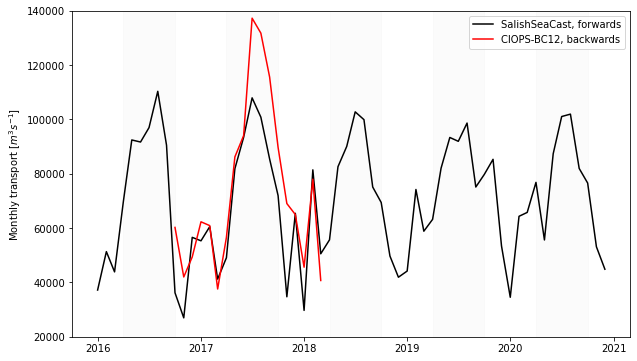

In [18]:
# compare sum transports
fig, ax = plt.subplots(1,1, figsize=[10,6])
ax.plot(dates, sum_trans, 'k', label='SalishSeaCast, forwards')
ax.plot(Cdates, Csum_trans, 'r', label='CIOPS-BC12, backwards')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans), np.mean(sum_trans)], 'grey')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)+stat.stdev(sum_trans), np.mean(sum_trans)+stat.stdev(sum_trans)], 'r--')
# ax.plot([dates[0], dates[-1]],[np.mean(sum_trans)-stat.stdev(sum_trans), np.mean(sum_trans)-stat.stdev(sum_trans)], 'b--')
ax.legend()
ax.set_ylim([20000,140000])
ax.set_ylabel("Monthly transport [$m^3 s^{-1}$]")

ax.fill_between(dates, 20000,140000, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 20000,140000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 20000,140000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 20000,140000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 20000,140000, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4);

In [52]:
# lets calculate the peason's correlation coefficient 
corr, _ = scipy.stats.pearsonr(sum_trans[9:27], Csum_trans)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.883


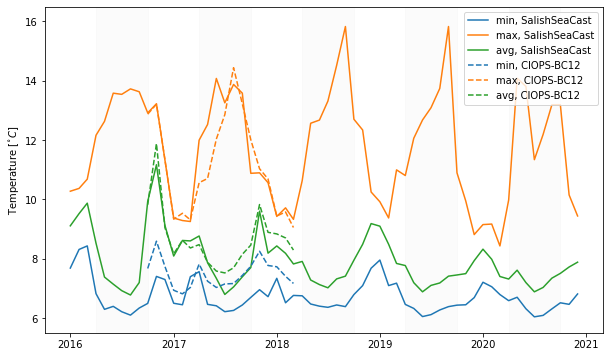

In [19]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_temp, label='min, SalishSeaCast', color='tab:blue')
ax.plot(dates, max_temp, label='max, SalishSeaCast', color='tab:orange')
ax.plot(dates, avg_temp, label='avg, SalishSeaCast', color='tab:green')
ax.plot(Cdates, Ctemp_min, label='min, CIOPS-BC12', ls='--', color='tab:blue')
ax.plot(Cdates, Ctemp_max, label='max, CIOPS-BC12', ls='--', color='tab:orange')
ax.plot(Cdates, Ctemp_avg, label='avg, CIOPS-BC12', ls='--', color='tab:green')
ax.legend()
ax.set_ylim([5.5, 16.5])

ax.fill_between(dates, 5,17, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 5,17, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 5,17, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 5,17, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 5,17, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4);

ax.set_ylabel('Temperature [$^{\circ}C$]'); 

In [31]:
diff = np.mean(abs(avg_temp[9:27] - Ctemp_avg))
# diff = np.mean((avg_temp[9:27] - Ctemp_avg))
print("average average temeprature difference : %.3f" % diff)
diff = np.mean(abs(max_temp[9:27] - Ctemp_max))
print("average max temeprature difference : %.3f" % diff)
diff = np.mean(abs(min_temp[9:27] - Ctemp_min))
print("average min temeprature difference : %.3f" % diff)

average average temeprature difference : 0.387
average max temeprature difference : 0.492
average min temeprature difference : 0.753


In [54]:
corr, _ = scipy.stats.pearsonr(avg_temp[9:27], Ctemp_avg)
print('Pearsons correlation of avg: %.3f' % corr)

corr, _ = scipy.stats.pearsonr(max_temp[9:27], Ctemp_max)
print('Pearsons correlation of max: %.3f' % corr)

corr, _ = scipy.stats.pearsonr(min_temp[9:27], Ctemp_min)
print('Pearsons correlation of min: %.3f' % corr)

Pearsons correlation of avg: 0.940
Pearsons correlation of max: 0.897
Pearsons correlation of min: 0.569


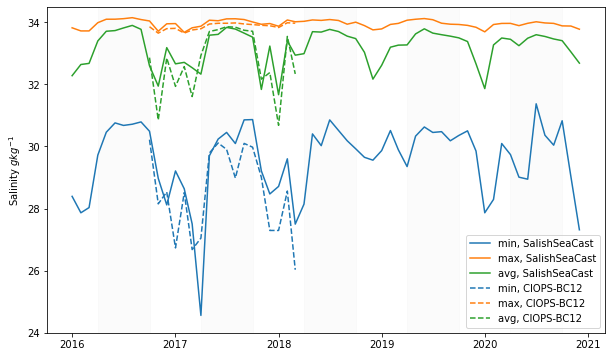

In [20]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_salt, label='min, SalishSeaCast', color='tab:blue')
ax.plot(dates, max_salt, label='max, SalishSeaCast', color='tab:orange')
ax.plot(dates, avg_salt, label='avg, SalishSeaCast', color='tab:green')
ax.plot(Cdates, Csal_min, label='min, CIOPS-BC12', ls='--', color='tab:blue')
ax.plot(Cdates, Csal_max, label='max, CIOPS-BC12', ls='--', color='tab:orange')
ax.plot(Cdates, Csal_avg, label='avg, CIOPS-BC12', ls='--', color='tab:green')
ax.legend()

ax.set_ylim([24, 34.5])

ax.fill_between(dates, 23,35, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 23,35, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 23,35, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 23,35, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)
ax.fill_between(dates, 23,35, where=(dates<dates[57+1])&(dates>=dates[51]), color='whitesmoke', alpha=0.4);

ax.set_ylabel('Salinity $g kg^{-1}$'); 

In [56]:
corr, _ = scipy.stats.pearsonr(avg_salt[9:27], Csal_avg)
print('Pearsons correlation of avg: %.3f' % corr)

corr, _ = scipy.stats.pearsonr(max_salt[9:27], Csal_max)
print('Pearsons correlation of max: %.3f' % corr)

corr, _ = scipy.stats.pearsonr(min_salt[9:27], Csal_min)
print('Pearsons correlation of min: %.3f' % corr)

Pearsons correlation of avg: 0.877
Pearsons correlation of max: 0.934
Pearsons correlation of min: 0.760


In [28]:
diff = np.mean(abs(avg_salt[9:27] - Csal_avg))
print("average average salinity difference : %.3f" % diff)
diff = np.mean(abs(max_salt[9:27] - Csal_max))
print("average max salinity difference : %.3f" % diff)
diff = np.mean(abs(min_salt[9:27] - Csal_min))
print("average min salinity difference : %.3f" % diff)

average average salinity difference : 0.424
average max salinity difference : 0.096
average min salinity difference : 0.903


## lets look at climatology jsut to show how variable the winter versus summer is

In [10]:
path = Path("/results/SalishSea/month-avg.201905/")
climate =xr.open_mfdataset(sorted(path.glob(f"SalishSea_1m_201*_grid_T.nc"))) 

In [28]:
jan = np.array([])
feb = np.array([])
mar = np.array([])
apr = np.array([])
may = np.array([])
jun = np.array([])
jul = np.array([])
aug = np.array([])
sep = np.array([])
oco = np.array([])
nov = np.array([])
dec = np.array([])

In [29]:
salt

<xarray.DataArray 'vosaline' (time_counter: 120, deptht: 40, y: 898, x: 398)>
dask.array<concatenate, shape=(120, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... 2019...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_reference_salinity
    long_name:           salinity
    units:               g kg-1
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s) time_counter: mean
    cell_measures:       area: area

In [26]:
for i in range(len(salt.time_counter)):
    if salt.time_counter[i].dt.month == 1:
        np.append(jan, salt)

salt.time_counter[0].dt.month

<xarray.DataArray 'month' ()>
array(1)
Coordinates:
    time_centered  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 2010-01-16T12:00:00